# CV project

## import libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from skimage.metrics import structural_similarity as ssim
from tensorflow import keras
from IPython.display import SVG
from tensorflow.keras.utils import plot_model

## functions

In [ ]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.show()

def remove_shadow(image: np.ndarray, blockSize):
  mean = cv2.blur(image, (blockSize, blockSize))
  no_shadow = image / mean
  return cv2.normalize(no_shadow, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)


def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

def transform(image,cornerpoints):
  cornerpoints = reorder(cornerpoints)
  print(cornerpoints)
  # Assign the corner points to variables
  (w1, w2, h1, h2) = cornerpoints

  # Calculate the width and height of the image
  FirstWidth = np.sqrt((((w2[1] - w1[1]) ** 2) + (w2[0] - w1[0]) ** 2))
  SecondWidth = np.sqrt((((h1[1] - h2[1]) ** 2) + (h1[0] - h2[0]) ** 2))
  FirstHeight = np.sqrt((((w2[1] - h1[1]) ** 2) + (w2[0] - h1[0]) ** 2))
  SecondHeight = np.sqrt((((w1[1] - h2[1]) ** 2) + (w1[0] - h2[0]) ** 2))

  # Determine the best width and height
  BestWidth = max(int(FirstWidth), int(SecondWidth))
  BestHeight = max(int(FirstHeight), int(SecondHeight))

  # Define the destination points for the perspective transform
  a = [0, 0]
  b = [BestWidth - 1, 0]
  c = [BestWidth - 1, BestHeight - 1]
  d = [0, BestHeight - 1]
  dest = np.array([ a, b, c, d], dtype = "float32")

  # Get the perspective transform matrix
  M = cv2.getPerspectiveTransform(cornerpoints, dest)

  # Apply the perspective transform to the image
  finalimg = cv2.warpPerspective(image, M, (BestWidth, BestHeight))

  # # Display the cropped image
  # plt.imshow(finalimg )
  return  finalimg

def project(image):
  img1=image.copy()
  grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype('uint8')
  bilateralimg = cv2.bilateralFilter(grayimg, 10, 10, 10)
  th2 = cv2.adaptiveThreshold(bilateralimg,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,5,2)
  edgesimg = cv2.Canny(th2, 50, 60, None, 3)
  kernel_dilate = np.ones((5, 5), np.uint8)
  img_dilate = cv2.dilate(edgesimg , kernel_dilate, iterations=1)

  # Find contours in the image
  contours, hierarchy = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  max_area = 0
  max_contour = []
  for c in contours:
      # Find the contour perimeter
      perimeter = cv2.arcLength(c, True)
      # Approximate the paper's contour with approxPolyDP function
      approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
      area = cv2.contourArea(c)
      cornerpoints=[]
      # If the contour has four sides, show it
      if len(approx) ==4 and area>max_area:
          max_area = area
          max_contour = approx
      # print(len(max_contour))
  if len(max_contour)>0:
        cv2.drawContours(img1, [max_contour], -1, (0, 255, 0), 2)
        for point in max_contour:
            x, y = point.ravel()
            cornerpoints.append([x,y])
  cornerpoints=np.array(cornerpoints, dtype = 'object')
  cornerpoints=np.float32(cornerpoints)
  print(cornerpoints)
  plt.scatter([x for x, y in cornerpoints], [y for x, y in cornerpoints])
  imshow(img1)
  img2=image.copy()
  finalimg=transform(img2,cornerpoints)
  return   finalimg

## Part a - Pretrain code

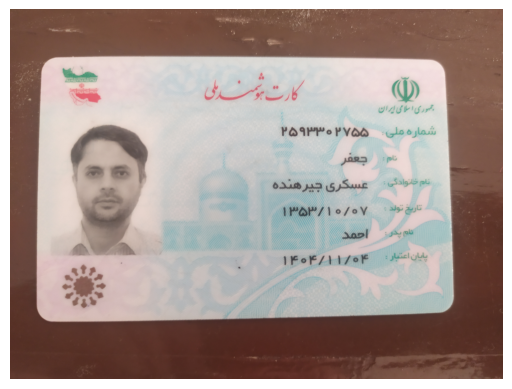

In [ ]:
# your code here #
# your code here #
filename = '09.jpg'
# filename = 'examples/1.png'
image = cv2.imread(filename)
imshow(image)

[[3525.  463.]
 [ 260.  418.]
 [ 226. 2473.]
 [3559. 2450.]]


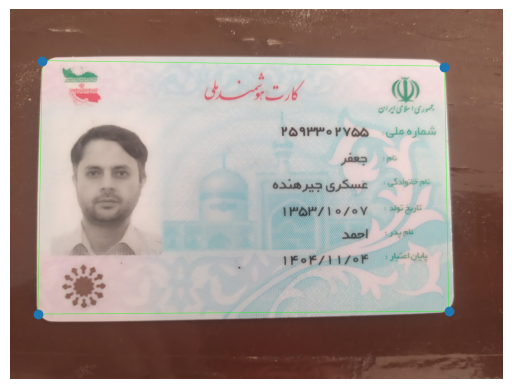

[[ 260.  418.]
 [3525.  463.]
 [3559. 2450.]
 [ 226. 2473.]]
(2055, 3333, 3)


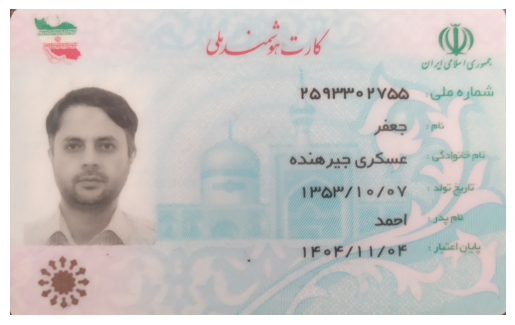

In [ ]:
finalimg=project(image)
print(finalimg.shape)
imshow(finalimg)

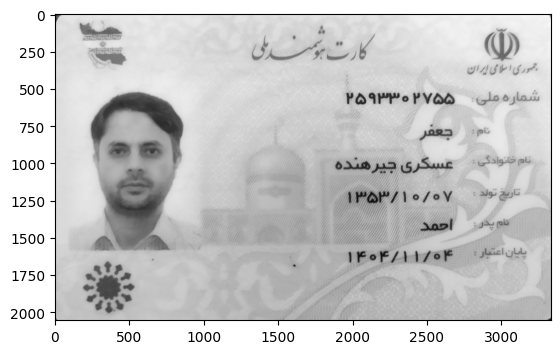

In [ ]:
finalgray=cv2.cvtColor(finalimg , cv2.COLOR_BGR2GRAY)
plt.imshow(finalgray,cmap='gray')

## pat b - predict images

### template matching

(60, 60)


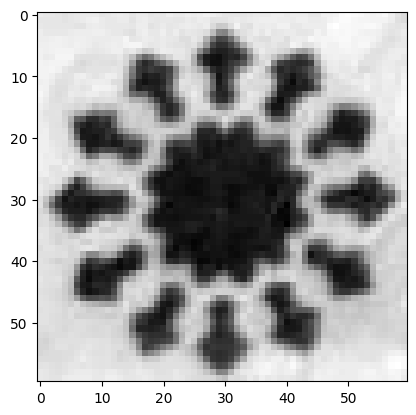

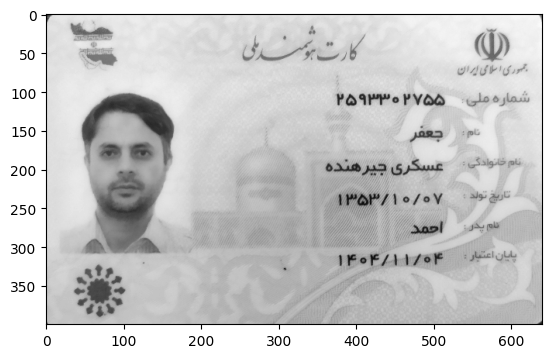

In [ ]:
finalgrayresize=cv2.resize(finalgray, (640,400))
# _, finalgrayresize = cv2.threshold(finalgray, 0, 255, cv2.THRESH_OTSU, cv2.THRESH_BINARY)
# your code here #
id_template=cv2.imread('template.jpg')
id_templategray=cv2.cvtColor(id_template , cv2.COLOR_BGR2GRAY)
id_templategray = cv2.resize(id_templategray, (60, 60))
# id_templategray = cv2.adaptiveThreshold(id_templategray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 5)
print(id_templategray.shape)

plt.imshow(id_templategray,cmap='gray')
plt.show()
plt.imshow(finalgrayresize,cmap='gray')
h,w=id_templategray.shape

# crop_img = finalgray[170:220,10:50]
# plt.imshow(crop_img,cmap='gray')
# print(crop_img.shape)

In [ ]:
def Cardrecognition(finalgrayresize,id_templategray):
  wb,hb=finalgrayresize.shape
  test_img=finalgrayresize.copy()
  typecard='Bank card'
  x, y = 70, 70
  # Perform template matching
  resized_template = cv2.resize(id_templategray, (x,y))
  # resized_template = cv2.adaptiveThreshold(resized_template, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 7)
  result = cv2.matchTemplate(finalgrayresize, resized_template, cv2.TM_CCOEFF_NORMED)
  # Set a threshold for the result
  threshold = 0.7
  # Find the location of the template in the image where the result is greater than the threshold
  loc = np.where(result >= threshold)
  # Draw a rectangle around the template if found
  if loc[0].size > 0 and loc[1].size > 0:
    # print(loc)
    top_left = (loc[1][0], loc[0][0])
    bottom_right = (loc[1][0] + resized_template.shape[1], loc[0][0] + resized_template.shape[0])
    cv2.rectangle(test_img, top_left, bottom_right, (0, 0, 255), 2)
    typecard='National card'
    print(x,y)
  print(typecard)
  # plt.imshow(test_img,cmap='gray')
  plt.imshow(result,cmap='gray')
  plt.colorbar()
  plt.show()
  return typecard


70 70
National card


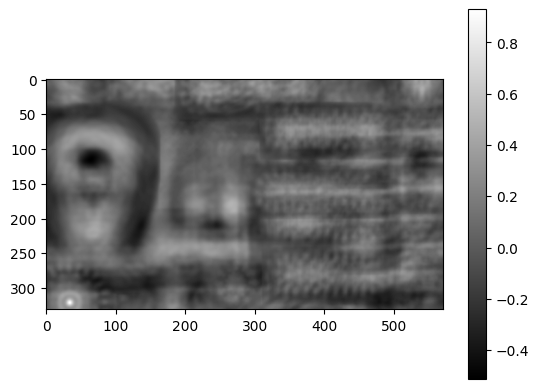

In [ ]:
typecard=Cardrecognition(finalgrayresize,id_templategray)

<h3>part 3</h3>

In [ ]:
def improveimgcrop(imagecrop):
  # Improve image quality
  finalimg1=imagecrop.copy()
  # Create a sharpening kernel
  kernel_sharpening = np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]])

  # Apply the sharpening kernel to the image
  sharpeimg = cv2.filter2D(finalimg1, -1, kernel_sharpening)

  # Convert the image to the HSV color space
  huesaturationvalue = cv2.cvtColor(sharpeimg, cv2.COLOR_BGR2HSV)

  # Split the image into its hue, saturation, and value components
  hue, saturation, value = cv2.split(huesaturationvalue)

  # Set a limit for the value and saturation channels
  lim = 255 - 40

  # Increase the brightness of the pixels with a low value channel
  value[value > lim] = 255
  value[value <= lim] += 30

  # Increase the saturation of the pixels with a low saturation channel
  saturation[saturation > lim] = 255
  saturation[saturation <= lim] += 35

  # Combine the hue, saturation, and value channels back into an image
  im3 = cv2.merge((hue, saturation, value))

  # Convert the image back to the BGR color space
  improveimg = cv2.cvtColor(im3, cv2.COLOR_HSV2BGR)
  return improveimg

def detectboxnumbers(typecard,imagecrop):
  if typecard=='National card':
    improveimg=improveimgcrop(imagecrop)
    improveimg=cv2.resize(improveimg,(1050,661))
    aa=improveimg.copy()
    ss=imagecrop.copy()
    ss=cv2.resize(ss,(1050,661))
    finalimggray=cv2.cvtColor(improveimg,cv2.COLOR_BGR2GRAY)

    # Threshold the image
    ret, thresh6 = cv2.threshold(finalimggray, 100, 255, cv2.THRESH_BINARY)

    # Apply the Sobel filter
    sobelx = cv2.Sobel(thresh6, cv2.CV_8U, 1, 0, ksize=3)
    sobelx=np.abs(sobelx)

    # # Apply thresholding to convert the image to black and white
    # thresh_value = 100
    # ret, thresh = cv2.threshold(sobelx, thresh_value, 255, cv2.THRESH_BINARY)


    # Define the vertical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))

    # Apply the morphological opening operation
    opened = cv2.morphologyEx(sobelx, cv2.MORPH_OPEN, kernel)

    # Define the horizontal structuring element
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (55, 8))

    # Apply the morphological closing operation
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel1)
    contours, hierarchy = cv2.findContours(closed,
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rectangles = []
    # Draw bounding rectangles for each contour
    for cnt in contours:
        # Calculate bounding rectangle for the contour
        x, y, w, h = cv2.boundingRect(cnt)
        # Draw the rectangle on the image
        x-=10
        y-=10
        w+=10
        h+=10
        if x>aa.shape[1]/2 and y<aa.shape[0]/2 and x>=0 and y>=0:
            # cv2.rectangle(aa, (x-10, y-10), (x + w, y + h), (0, 255, 0), 2)
            rectangles.append((x, y, w, h))

    # Find the rectangle with the largest width
    max_width_rectangle = max(rectangles, key=lambda x: x[2])
    # Sort the rectangles by y-coordinate
    rectangles_sorted_by_y = sorted(rectangles, key=lambda x: x[1])

    print(rectangles_sorted_by_y[1][0])

    for i in range(len(rectangles_sorted_by_y)):
        if rectangles_sorted_by_y[i][2]>0.8*max_width_rectangle[2]:
            x= rectangles_sorted_by_y[i][0]
            y=rectangles_sorted_by_y[i][1]
            w=rectangles_sorted_by_y[i][2]
            h=rectangles_sorted_by_y[i][3]
            cropped_image = ss[y:y+h, x:x+w]
            cv2.rectangle(aa, (x, y), (x + w, y + h), (0, 255, 0), 2)
            break
    imshow(aa)
    imshow(cropped_image)
    return cropped_image
  else:
    improveimg=improveimgcrop(imagecrop)
    improveimg=cv2.resize(improveimg,(1218,788))
    aa=improveimg.copy()
    ss=imagecrop.copy()
    ss=cv2.resize(ss,(1218,788))
    finalimggray=cv2.cvtColor(improveimg,cv2.COLOR_BGR2GRAY)


    # Apply the Sobel filter
    sobelx = cv2.Sobel(finalimggray, cv2.CV_8U, 1, 0, ksize=3)
    sobelx=np.abs(sobelx)

    # Apply thresholding to convert the image to black and white
    thresh_value = 100
    ret, thresh = cv2.threshold(sobelx, thresh_value, 255, cv2.THRESH_BINARY)


    # Define the vertical structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))

    # Apply the morphological opening operation
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Define the horizontal structuring element
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (90, 10))

    # Apply the morphological closing operation
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel1)

    imshow(closed )

    contours, hierarchy = cv2.findContours(closed ,
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    max_width = 0
    max_x = 0
    max_y = 0
    max_h = 0

    # Draw bounding rectangles for each contour
    for cnt in contours:
        # Calculate bounding rectangle for the contour
        x, y, w, h = cv2.boundingRect(cnt)
        x-=10
        y-=10
        w+=10
        h+=10
        # Draw the rectangle on the image
        if y+h>(1/2)*aa.shape[0]:
            cv2.rectangle(aa, (x, y), (x + w, y + h), (0, 255, 0), 2)
            if w > max_width:
                max_width = w
                max_x = x
                max_y = y
                max_h = h
                cv2.rectangle(aa, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Crop the image using the coordinates of the bounding rectangle with maximum width
    crop_img = ss[max_y:max_y+max_h, max_x:max_x+max_width]
    imshow(aa)
    return crop_img


647


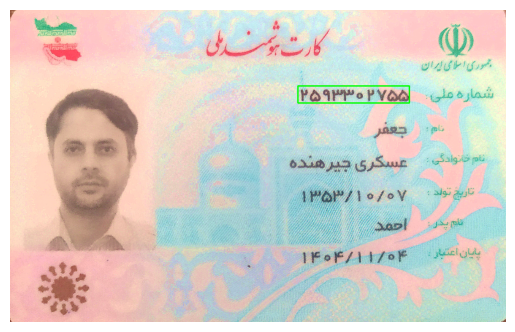

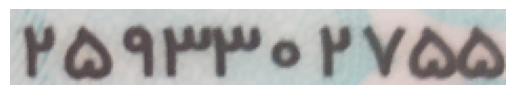

(36, 236, 3)


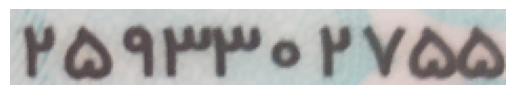

True

In [ ]:
boxnum=detectboxnumbers(typecard,finalimg)
print(boxnum.shape)
imshow(boxnum)
cv2.imwrite('test.jpg',boxnum)

In [ ]:
def splitdigit(boxnum):
  ee=boxnum.copy()
  ee=cv2.resize(ee,(1071,79))
  kk=ee.copy()
  # Convert the image to grayscale
  gray = cv2.cvtColor(kk, cv2.COLOR_BGR2GRAY)

  # Apply thresholding to convert the image to black and white
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  kernel_dilate = np.ones((3, 3), np.uint8)

  # Apply the dilation operation to the threshold image
  thresh1 = cv2.erode(thresh  , kernel_dilate, iterations=1)

  imshow(thresh1)
  # Find the contours in the binary image
  contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Initialize a list to store the x coordinates of the bounding rectangles
  x_values = []

  # Loop over the contours
  for contour in contours:
      # Get the bounding rectangle of the contour
      x, y, w, h = cv2.boundingRect(contour)
      # Append the x coordinate of the bounding rectangle to the list
      x_values.append(x)

  # Sort the bounding rectangles based on their x coordinates
  sorted_contours = [contours[i] for i in np.argsort(x_values)]
  # Loop over the sorted contours
  listgigit=[]
  for contour in sorted_contours:
      # Get the bounding rectangle of the contour
      x, y, w, h = cv2.boundingRect(contour)
      # Crop the contour from the image
      if w>boxnum.shape[1]/50:
          digit = thresh1[y:y+h, x:x+w]
          listgigit.append(digit)
          # resize = cv2.resize(digit, (28, 28))
          # imshow(digit)
  return listgigit


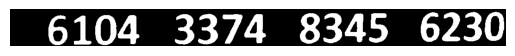

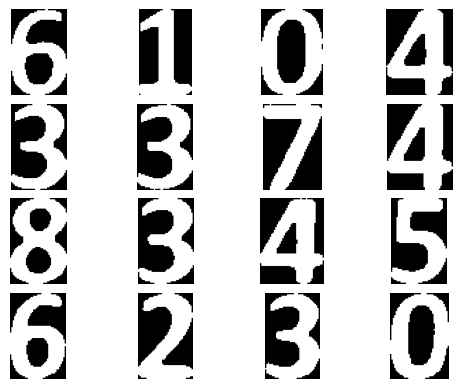

In [ ]:
digits=splitdigit(boxnum)

# Define the number of rows and columns for the plot
nrows = 4
ncols = 4

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

# Flatten the axis objects to simplify indexing
axes = axes.flatten()

# Loop over all images and plot them
for i, img in enumerate(digits):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

### create your model

In [ ]:
# load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Convert class vectors to binary class matrices.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
x_train = x_train.astype(float) / 255.
x_test  = x_test.astype(float) / 255.

In [ ]:
# Reshape input images to (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [ ]:
# Define model
modelnumbank = keras.Sequential()

# Input layer
modelnumbank.add(keras.layers.Input(shape=x_train[0].shape))

# Convolutional layer
modelnumbank.add(keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu'))

# Max pooling layer
modelnumbank.add(keras.layers.MaxPooling2D())

# Convolutional layer
modelnumbank.add(keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))

# Max pooling layer
modelnumbank.add(keras.layers.MaxPooling2D())

# Flatten layer
modelnumbank.add(keras.layers.Flatten(input_shape=x_train[0].shape))

# Fully connected layer
modelnumbank.add(keras.layers.Dense(units=120, activation='relu'))

# Fully connected layer
modelnumbank.add(keras.layers.Dense(units=84, activation='relu'))

# Output layer
modelnumbank.add(keras.layers.Dense(units=num_classes, activation='softmax'))

modelnumbank.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [ ]:
# compile model
modelnumbank.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train model
historybank = modelnumbank.fit(x_train, y_train,
                    batch_size=100,
                    epochs=50,
                    validation_data=(x_test, y_test),
                    shuffle=True)

Epoch 1/50
600/600 [==============================] - 43s 69ms/step - loss: 0.2782 - accuracy: 0.9187 - val_loss: 0.0772 - val_accuracy: 0.9761
Epoch 2/50
600/600 [==============================] - 32s 54ms/step - loss: 0.0740 - accuracy: 0.9771 - val_loss: 0.0575 - val_accuracy: 0.9807
Epoch 3/50
600/600 [==============================] - 32s 54ms/step - loss: 0.0511 - accuracy: 0.9841 - val_loss: 0.0516 - val_accuracy: 0.9840
Epoch 4/50
600/600 [==============================] - 33s 55ms/step - loss: 0.0420 - accuracy: 0.9870 - val_loss: 0.0377 - val_accuracy: 0.9881
Epoch 5/50
600/600 [==============================] - 33s 55ms/step - loss: 0.0344 - accuracy: 0.9891 - val_loss: 0.0365 - val_accuracy: 0.9886
Epoch 6/50
600/600 [==============================] - 33s 54ms/step - loss: 0.0301 - accuracy: 0.9908 - val_loss: 0.0328 - val_accuracy: 0.9890
Epoch 7/50
600/600 [==============================] - 32s 54ms/step - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.0430 - val_accuracy:

In [ ]:
modelnumbank.save('weightsdigiten.h5')

In [ ]:
from keras.models import load_model
modelnumbank = load_model('/content/weightsdigiten.h5')

In [ ]:
def predictnumbank(img):
  # Define the border size
  border_size = 25

  # Define the border color
  border_color = [0, 0, 0]  # Black color
  # Add the border to the image
  img_with_border = cv2.copyMakeBorder(img, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=border_color)
  # kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  # # Apply the morphological closing operation
  # img_with_border= cv2.morphologyEx(img_with_border, cv2.MORPH_CLOSE, kernel1)
  # Preprocess the image
  # img = cv2.cvtColor(img_with_border, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img_with_border, (28, 28))
  img = img.astype(float) / 255.
  img = np.expand_dims(img, axis=-1)
  img = np.expand_dims(img, axis=0)
  # imshow(img_with_border)
  # Make a prediction
  y = modelnumbank.predict(img)

  # Print the predicted class
  # print(np.argmax(y))
  # print(y)
  return np.argmax(y)


1/1 [==============================] - 0s 18ms/step
6104337483455230


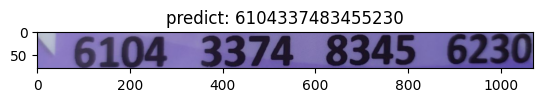

In [ ]:
num=''
for d in digits:
  # print(str(predictnumbank(d)))
  num+=str(predictnumbank(d))
  # imshow(d)
print(num)

plt.imshow(boxnum)
plt.title('predict: {}'.format(num))
plt.show()


<h4>predictnum nationalcard</h4>

In [ ]:
import zipfile
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_path = '/content/drive/MyDrive/HodaDatasetReader.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [ ]:
X_train, Y_train = read_hoda_dataset(dataset_path='/content/HodaDatasetReader/DigitDB/Train 60000.cdb',
                                images_height=28,
                                images_width=28,
                                one_hot=False,
                                reshape=True)


X_test, Y_test = read_hoda_dataset(dataset_path='/content/HodaDatasetReader/DigitDB/Test 20000.cdb',
                              images_height=28,
                              images_width=28,
                              one_hot=True,
                              reshape=False)

<ipython-input-56-1828c60aed50>:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.zeros(shape=[len(labels)], dtype=np.int)


In [ ]:
print(Y_train[8])
X_train_fa= np.zeros((60000, 28, 28))
X_test_fa= np.zeros((20000, 28, 28))

Y_train_fa= np.zeros(60000)
Y_test_fa= np.zeros(20000)
for i in range(len(X_train)):
    X_train_fa[i] = X_train[i].reshape([28, 28])
    Y_train_fa[i]=Y_train[i]
for i in range(20000):
    X_test_fa[i] = X_test[i].reshape([28, 28])
    Y_test_fa[i]=np.argmax(Y_test[i])

0.0


In [ ]:
# Convert class vectors to binary class matrices.
num_classes = 10
Y_train_fa = keras.utils.to_categorical(Y_train_fa, num_classes)
Y_test_fa = keras.utils.to_categorical(Y_test_fa, num_classes)

In [ ]:
X_train_fa = X_train_fa.astype(float) / 255.
X_test_fa  = X_test_fa.astype(float) / 255.

In [ ]:
X_train_fa = np.expand_dims(X_train_fa, axis=-1)
X_test_fa  = np.expand_dims(X_test_fa, axis=-1)

In [ ]:
# Define model
modelnational = keras.Sequential()

# Input layer
modelnational.add(keras.layers.Input(shape=X_train_fa[0].shape))

# Convolutional layer
modelnational.add(keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu'))

# Max pooling layer
modelnational.add(keras.layers.MaxPooling2D())

# Convolutional layer
modelnational.add(keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))

# Max pooling layer
modelnational.add(keras.layers.MaxPooling2D())

# Flatten layer
modelnational.add(keras.layers.Flatten(input_shape=X_train_fa[0].shape))

# Fully connected layer
modelnational.add(keras.layers.Dense(units=120, activation='relu'))

# Fully connected layer
modelnational.add(keras.layers.Dense(units=84, activation='relu'))

# Output layer
modelnational.add(keras.layers.Dense(units=num_classes, activation='softmax'))

modelnational.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)              

In [ ]:
# compile model
modelnational.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train model
historynational = modelnational.fit(X_train_fa, Y_train_fa,
                    batch_size=100,
                    epochs=50,
                    validation_data=(X_test_fa, Y_test_fa),
                    shuffle=True)

Epoch 1/50
600/600 [==============================] - 34s 53ms/step - loss: 0.7267 - accuracy: 0.7687 - val_loss: 0.5036 - val_accuracy: 0.8242
Epoch 2/50
600/600 [==============================] - 30s 49ms/step - loss: 0.1979 - accuracy: 0.9413 - val_loss: 0.2717 - val_accuracy: 0.9162
Epoch 3/50
600/600 [==============================] - 34s 56ms/step - loss: 0.1261 - accuracy: 0.9626 - val_loss: 0.2193 - val_accuracy: 0.9296
Epoch 4/50
600/600 [==============================] - 30s 50ms/step - loss: 0.0961 - accuracy: 0.9705 - val_loss: 0.1619 - val_accuracy: 0.9488
Epoch 5/50
600/600 [==============================] - 30s 50ms/step - loss: 0.0780 - accuracy: 0.9761 - val_loss: 0.1351 - val_accuracy: 0.9580
Epoch 6/50
600/600 [==============================] - 30s 50ms/step - loss: 0.0669 - accuracy: 0.9791 - val_loss: 0.1197 - val_accuracy: 0.9629
Epoch 7/50
600/600 [==============================] - 30s 50ms/step - loss: 0.0592 - accuracy: 0.9813 - val_loss: 0.1214 - val_accuracy:

In [ ]:
modelnational.save('weightsdigitenfarsi.h5')

In [ ]:
from keras.models import load_model
modelnational = load_model('/content/weightsdigitenfarsi.h5')

In [ ]:
def splitdigitnational(boxnum):
  ee=boxnum.copy()

  # Convert the image to grayscale
  gray = cv2.cvtColor(boxnum, cv2.COLOR_BGR2GRAY)
  ll=cv2.resize(gray,(600,200))
  # Apply thresholding to convert the image to black and white
  thresh = cv2.threshold(  ll, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

  # kernel_dilate = np.ones((3, 3), np.uint8)

  # # Apply the dilation operation to the threshold image
  # thresh1 = cv2.erode(thresh  , kernel_dilate, iterations=1)
  imshow(ll)
  imshow(thresh)
  # Find the contours in the binary image
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Initialize a list to store the x coordinates of the bounding rectangles
  x_values = []

  # Loop over the contours
  for contour in contours:
      # Get the bounding rectangle of the contour
      x, y, w, h = cv2.boundingRect(contour)
      # Append the x coordinate of the bounding rectangle to the list
      x_values.append(x)

  # Sort the bounding rectangles based on their x coordinates
  sorted_contours = [contours[i] for i in np.argsort(x_values)]
  # Loop over the sorted contours
  listgigit=[]
  for contour in sorted_contours:
      # Get the bounding rectangle of the contour
      x, y, w, h = cv2.boundingRect(contour)
      # Crop the contour from the image
      if w>boxnum.shape[1]/20:
          if w>boxnum.shape[1]/3:
            digit1 = thresh[y:y+h, x:x+int(w/2)]
            digit2 = thresh[y:y+h, x+int(w/2):x+w]
            listgigit.append(digit1)
            listgigit.append(digit2)
            imshow(digit1)
            imshow(digit2)
          else:
            digit = thresh[y:y+h, x:x+w]
            listgigit.append(digit)
          # resize = cv2.resize(digit, (28, 28))
            # imshow(digit)
  return listgigit

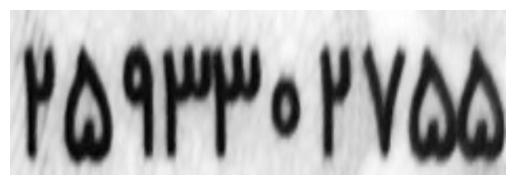

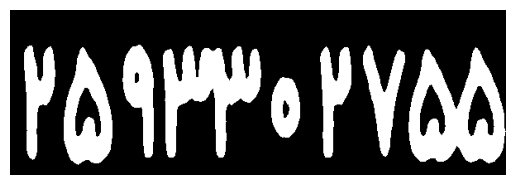

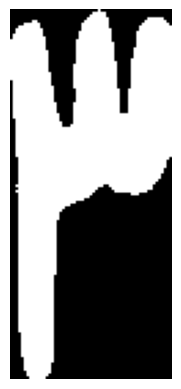

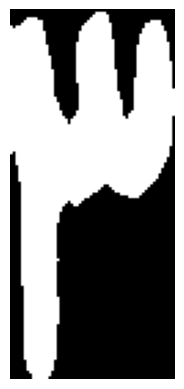

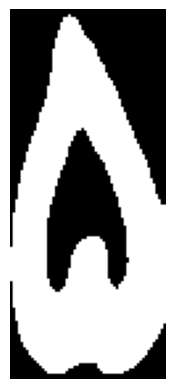

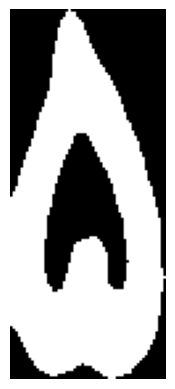

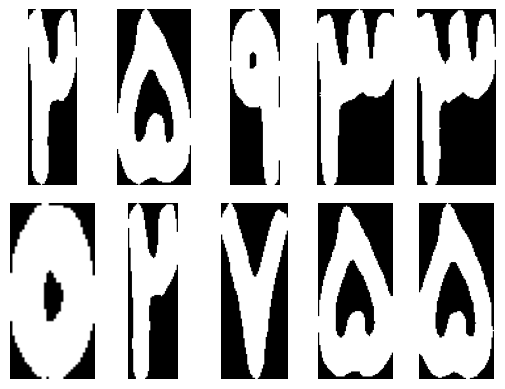

In [ ]:
digitn=splitdigitnational(boxnum)


# Define the number of rows and columns for the plot
nrows = 2
ncols = 5

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

# Flatten the axis objects to simplify indexing
axes = axes.flatten()

# Loop over all images and plot them
for i, img in enumerate(digitn):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [ ]:
def predictnumnational(img):
  # Define the border size
  border_size = 2

  # Define the border color
  border_color = [0, 0, 0]  # Black color
  # Add the border to the image
  img_with_border = cv2.copyMakeBorder(img, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=border_color)
  # kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  # # Apply the morphological closing operation
  # img_with_border= cv2.morphologyEx(img_with_border, cv2.MORPH_CLOSE, kernel1)
  # Preprocess the image
  # img = cv2.cvtColor(img_with_border, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img_with_border, (28, 28))
  img = img.astype(float) / 255.
  img = np.expand_dims(img, axis=-1)
  img = np.expand_dims(img, axis=0)
  # imshow(img_with_border)
  # Make a prediction
  y = modelnational.predict(img)
  return np.argmax(y)

1/1 [==============================] - 0s 32ms/step
2563302755


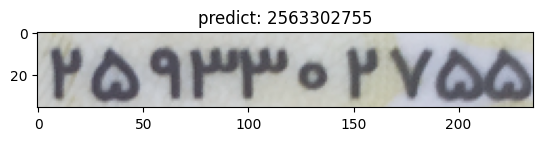

In [ ]:
num=''
for d in digitn:
  # print(str(predictnumbank(d)))
  num+=str(predictnumnational(d))
  # imshow(d)
print(num)

plt.imshow(boxnum)
plt.title('predict: {}'.format(num))
plt.show()


part 4

In [ ]:
Y_train_fa1= np.zeros(60000)
Y_test_fa1= np.zeros(20000)

y_train1=np.ones(60000)
y_test1=np.ones(10000)

In [ ]:
# Merge the two datasets
x_train1 = np.concatenate((x_train, X_train_fa))
y_train1 = np.concatenate((y_train1,Y_train_fa1))
x_test1 = np.concatenate((x_test, X_test_fa))
y_test1 = np.concatenate((y_test1,Y_test_fa1))

In [ ]:
# Shuffle the training and testing data along with their labels
rng = np.random.default_rng()
train_indices = rng.permutation(len(x_train))
test_indices = rng.permutation(len(x_test))
x_train, y_train = x_train[train_indices], y_train[train_indices]
x_test, y_test = x_test[test_indices], y_test[test_indices]

In [ ]:
# Normalize the pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape the input data
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [ ]:
# Define the model
modelfnoren = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
# Compile the model
modelfnoren.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = modelfnoren.fit(x_train1, y_train1,
                    batch_size=100,
                    epochs=10,
                    validation_data=(x_test1, y_test1),
                    shuffle=True)

Epoch 1/10
1200/1200 [==============================] - 81s 66ms/step - loss: 0.0065 - accuracy: 0.9991 - val_loss: 9.4562e-06 - val_accuracy: 1.0000
Epoch 2/10
1200/1200 [==============================] - 79s 65ms/step - loss: 3.5323e-06 - accuracy: 1.0000 - val_loss: 2.2360e-06 - val_accuracy: 1.0000
Epoch 3/10
1200/1200 [==============================] - 82s 68ms/step - loss: 1.0482e-06 - accuracy: 1.0000 - val_loss: 7.9997e-07 - val_accuracy: 1.0000
Epoch 4/10
1200/1200 [==============================] - 77s 64ms/step - loss: 4.2565e-07 - accuracy: 1.0000 - val_loss: 3.9945e-07 - val_accuracy: 1.0000
Epoch 5/10
1200/1200 [==============================] - 77s 65ms/step - loss: 1.9301e-07 - accuracy: 1.0000 - val_loss: 1.5990e-07 - val_accuracy: 1.0000
Epoch 6/10
1200/1200 [==============================] - 78s 65ms/step - loss: 9.2083e-08 - accuracy: 1.0000 - val_loss: 8.0093e-08 - val_accuracy: 1.0000
Epoch 7/10
1200/1200 [==============================] - 83s 69ms/step - loss: 6.

In [ ]:
# your code here #
!gdown "1dhUs08VWIYUq78gdCGTBbNKEK0aPns58&export=download"
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
         continuing with "central" filename version
  inflating: Dataset/datanationalcard/۸۳۵۲۱۳۷۷۰۹.jpg  
Dataset/datanationalcard/۸۳۵۳۶۳۴۶۸۲.jpg:  mismatching "local" filename (Dataset/datanationalcard/█╕█│█╡█│█╢█│█┤█╢█╕█▓.jpg),
         continuing with "central" filename version
  inflating: Dataset/datanationalcard/۸۳۵۳۶۳۴۶۸۲.jpg  
Dataset/datanationalcard/۸۳۵۴۱۶۷۳۵۰.jpg:  mismatching "local" filename (Dataset/datanationalcard/█╕█│█╡█┤█▒█╢█╖█│█╡█░.jpg),
         continuing with "central" filename version
  inflating: Dataset/datanationalcard/۸۳۵۴۱۶۷۳۵۰.jpg  
Dataset/datanationalcard/۸۳۵۷۶۵۶۱۴۴.jpg:  mismatching "local" filename (Dataset/datanationalcard/█╕█│█╡█╖█╢█╡█╢█▒█┤█┤.jpg),
         continuing with "central" filename version
  inflating: Dataset/datanationalcard/۸۳۵۷۶۵۶۱۴۴.jpg  
Dataset/datanationalcard/۸۳۵۸۱۶۶۷۴۲.jpg:  mismatching "local" filename (Dataset/datanationalcard/█╕█│█╡█╕█▒█╢█╢█╖█┤█▓.jpg),
         continuing with 

In [ ]:
from PIL import Image
import os

folder_path = "/content/Dataset/datanationalcard"

new_size = (200, 50)
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if filename.endswith(".jpg"):
      with Image.open(file_path) as img:
          img_resized = img.resize(new_size)
          img_resized.save(file_path)

In [ ]:

# Get list of all the images
# Path to the data directory
from pathlib import Path
data_dir = Path("/content/Dataset/datanationalcard")
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)


batch_size = 16
img_width = 200
img_height = 50
downsample_factor = 4
max_length = max([len(label) for label in labels])

Number of images found:  10000
Number of labels found:  10000
Number of unique characters:  10
Characters present:  ['۰', '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹']


In [ ]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

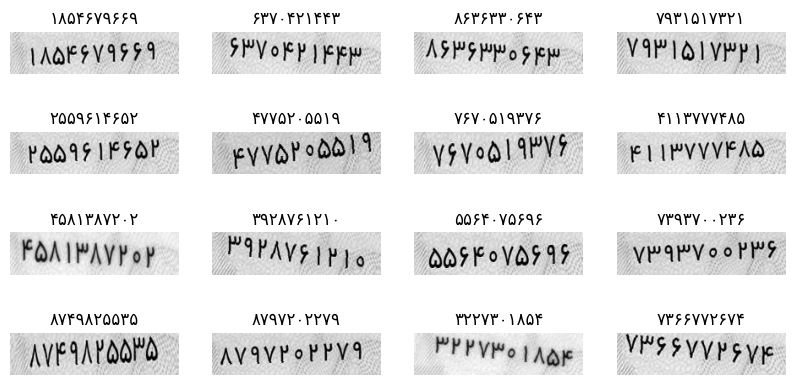

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

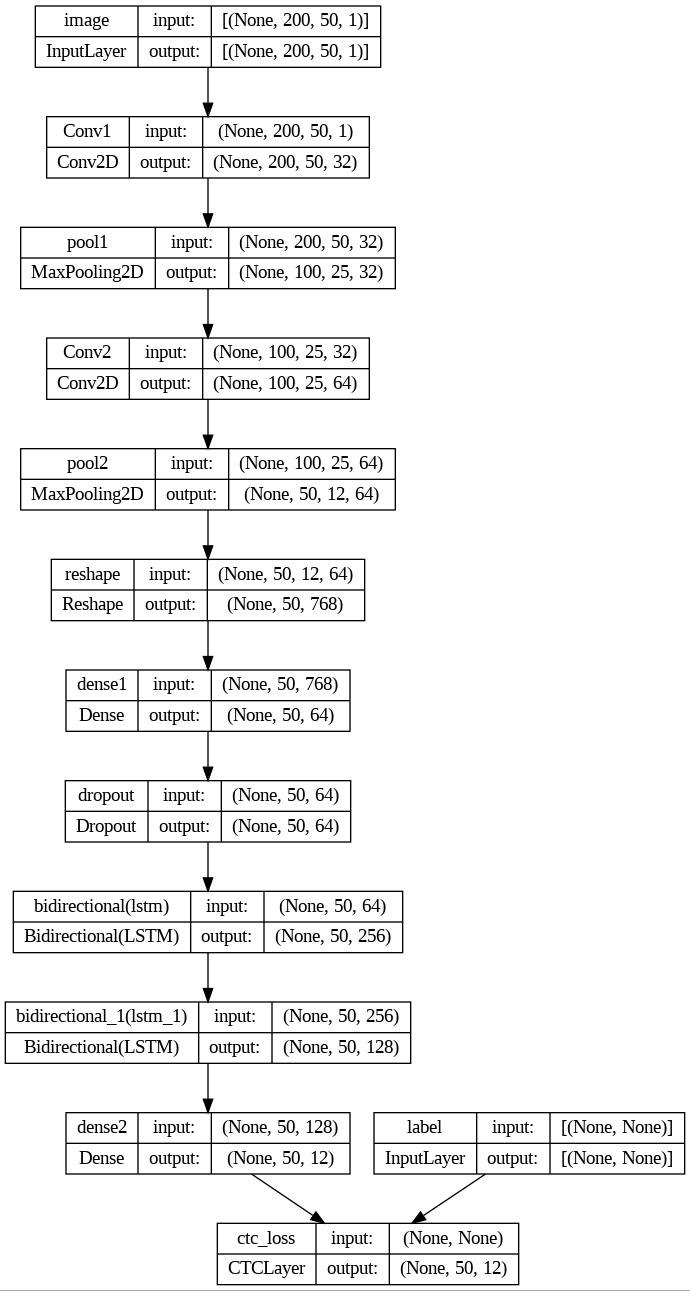

In [ ]:
plot_model(model,to_file="ocrmodel.jpg",show_shapes=True,show_layer_names=True)

In [ ]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
563/563 [==============================] - 42s 40ms/step - loss: 18.3638 - val_loss: 0.2596
Epoch 2/100
563/563 [==============================] - 22s 39ms/step - loss: 0.3111 - val_loss: 0.0187
Epoch 3/100
563/563 [==============================] - 20s 36ms/step - loss: 0.0978 - val_loss: 0.0107
Epoch 4/100
563/563 [==============================] - 20s 35ms/step - loss: 0.0713 - val_loss: 0.0058
Epoch 5/100
563/563 [==============================] - 20s 36ms/step - loss: 0.0409 - val_loss: 0.0042
Epoch 6/100
563/563 [==============================] - 21s 37ms/step - loss: 0.0428 - val_loss: 0.0015
Epoch 7/100
563/563 [==============================] - 19s 34ms/step - loss: 0.0351 - val_loss: 0.0013
Epoch 8/100
563/563 [==============================] - 20s 36ms/step - loss: 0.0227 - val_loss: 4.6529e-04
Epoch 9/100
563/563 [==============================] - 21s 37ms/step - loss: 0.0242 - val_loss: 4.4358e-04
Epoch 10/100
563/563 [==============================] - 20s 36ms

In [ ]:
model.save('nationalcardocr.h5')

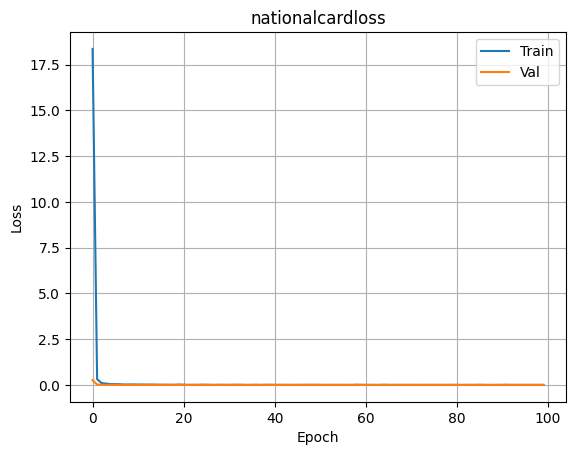

In [ ]:
def plot_loss(history, title):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.title(title)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.grid()
    plt.show()

plot_loss(history, 'nationalcardloss')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = keras.models.load_model('/content/nationalcardocr.h5', custom_objects={"CTCLayer": CTCLayer})

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

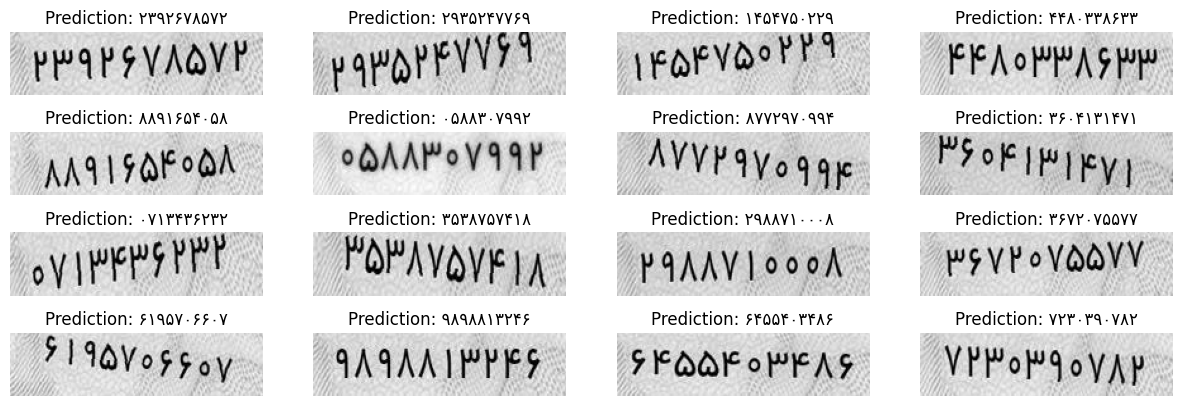

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
# test=cv2.imread('a.jpg',0)
# tt=cv2.resize(test,(200,50))
# plt.imshow(tt,cmap='gray')

# model.predict(tt)
def EncodeSingleSample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)

    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

def prediction(images):
    print("Number of images found: ", len(images), '\n')

    result = []

    test_dataset = tf.data.Dataset.from_tensor_slices((images, ['0' * 16] * len(images)))
    test_dataset = (
        test_dataset.map(
            EncodeSingleSample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    prediction_model = keras.models.Model(
        model.get_layer(name="image").input, model.get_layer(name="dense2").output
    )

    for batch in test_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        result = result + pred_texts

        plt.figure(figsize=(5,2 * len(batch_images)))
        for i in range(len(pred_texts)):
            plt.subplot(len(batch_images), 1, i + 1)

            img = (batch_images[i] * 255).numpy().astype(np.uint8)
            img = tf.transpose(img, perm=[1, 0, 2])
            title = f"Prediction: {pred_texts[i]}"
            plt.imshow(img)
            plt.title(title)

    return result


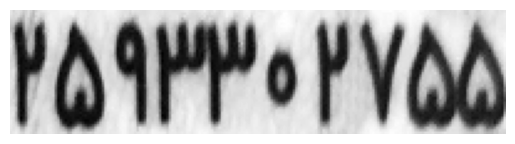

['/content/test.png']
Number of images found:  1 

1/1 [==============================] - 2s 2s/step


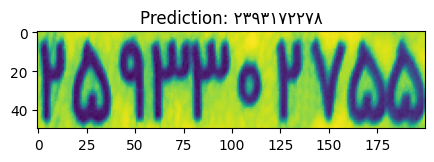

In [ ]:
test=cv2.imread('test.jpg',0)
tt=cv2.resize(test,(200,50))
plt.imshow(tt,cmap='gray')
filename = 'test.png'
cv2.imwrite(filename,tt)
imshow(tt)
images=[]
images.append('/content/test.png')
print(images)
results = prediction(images)

In [ ]:
import zipfile
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_path = '/content/drive/MyDrive/mypic.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/mypic/4.jpg
[[3525.  463.]
 [ 260.  418.]
 [ 226. 2473.]
 [3559. 2450.]]


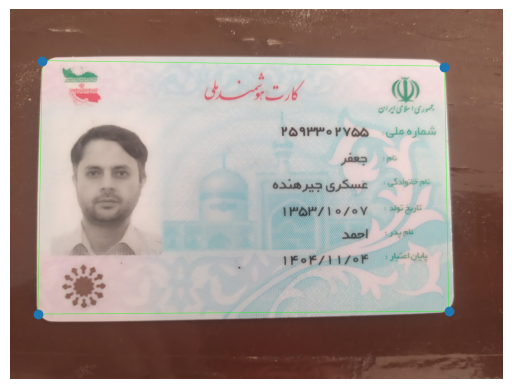

[[ 260.  418.]
 [3525.  463.]
 [3559. 2450.]
 [ 226. 2473.]]
70 70
National card


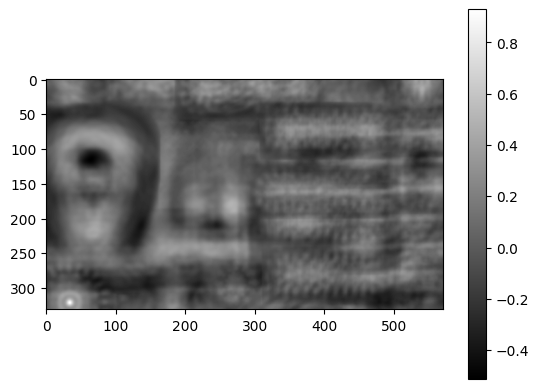

647


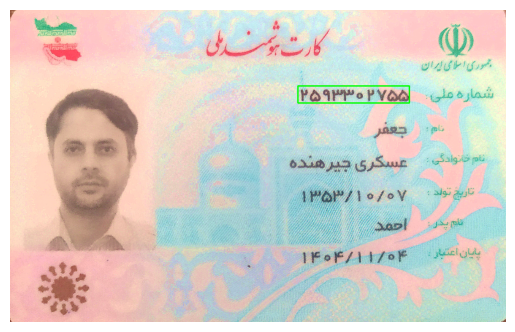

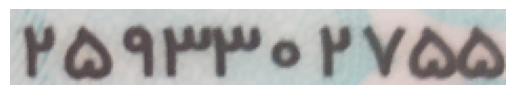

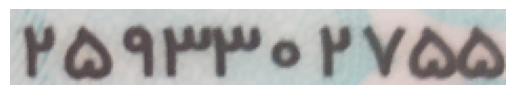

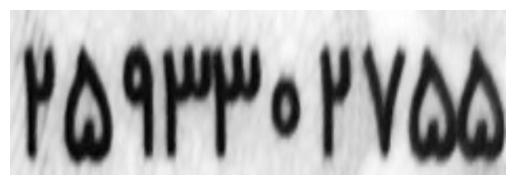

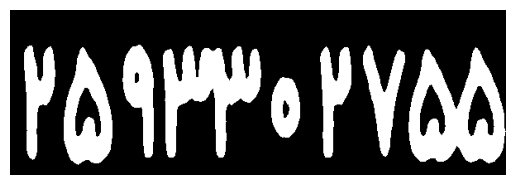

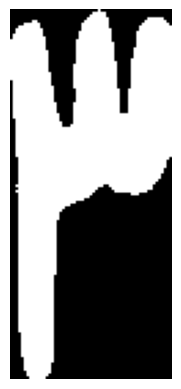

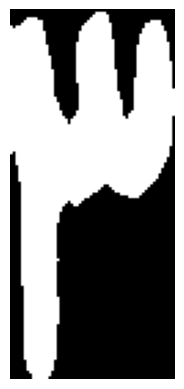

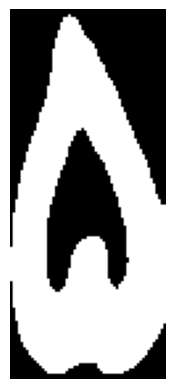

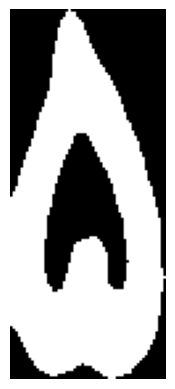

1/1 [==============================] - 0s 33ms/step
2563302755


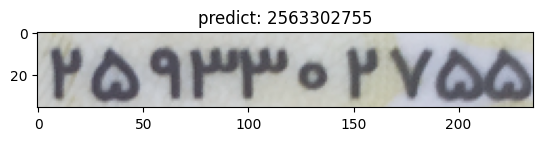

/content/mypic/2.jpg
[[  30.  145.]
 [  61.  905.]
 [1279.  910.]
 [1231.  123.]]


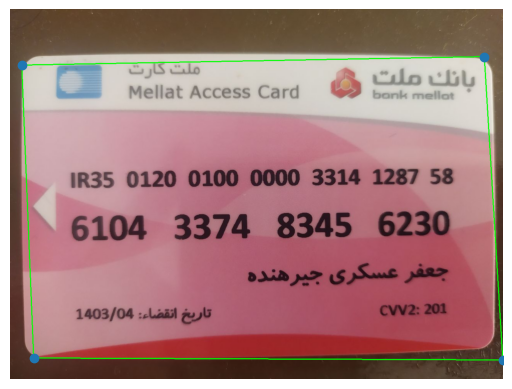

[[  30.  145.]
 [1231.  123.]
 [1279.  910.]
 [  61.  905.]]
Bank card


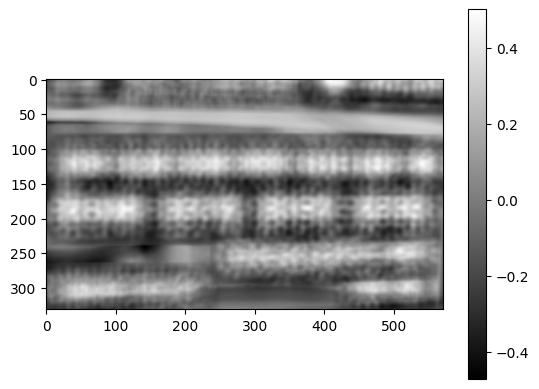

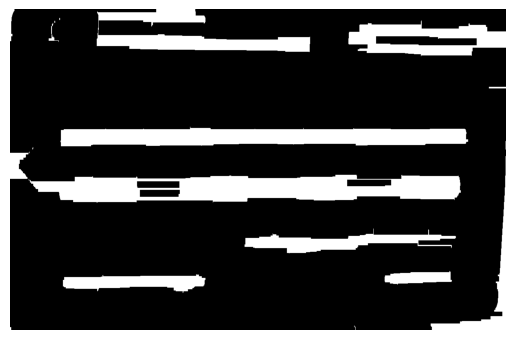

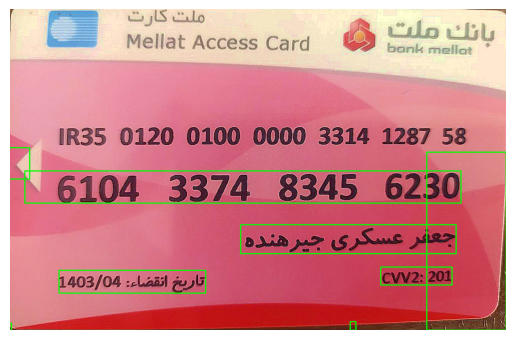

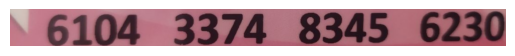

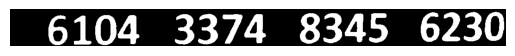

1/1 [==============================] - 0s 24ms/step
6104337483455230


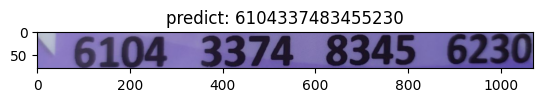

/content/mypic/3.jpg
[[ 149.  200.]
 [ 165.  861.]
 [1212.  833.]
 [1199.  187.]]


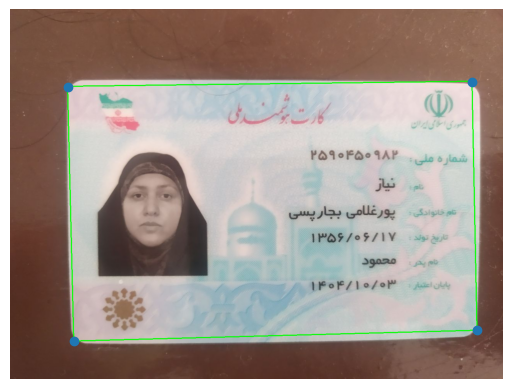

[[ 149.  200.]
 [1199.  187.]
 [1212.  833.]
 [ 165.  861.]]
70 70
National card


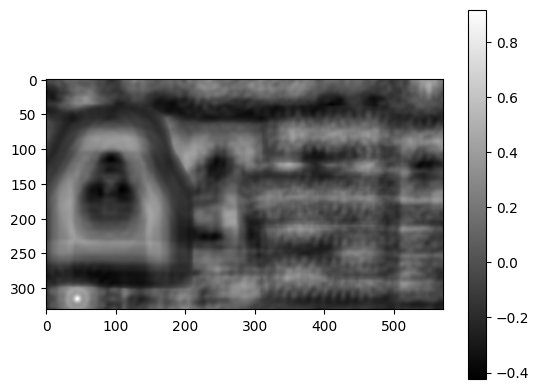

904


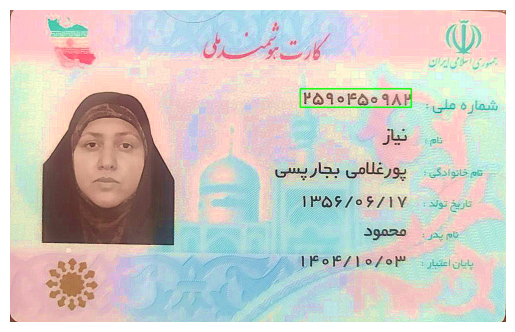

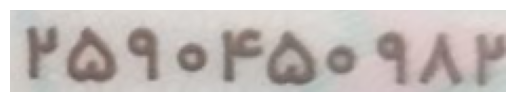

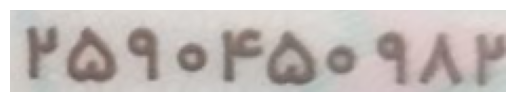

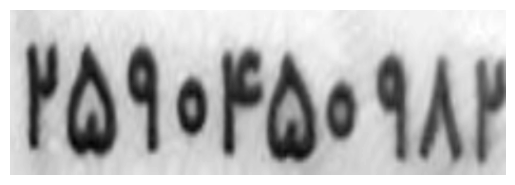

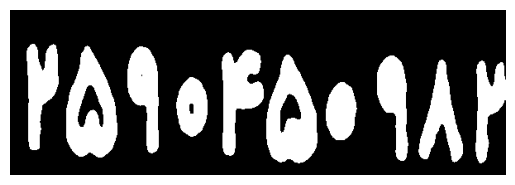

1/1 [==============================] - 0s 31ms/step
2560450682


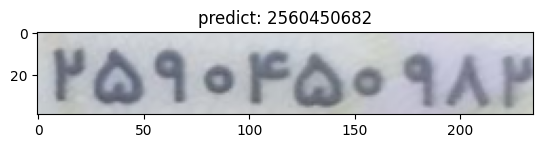

/content/mypic/1.jpg
[[1054.  453.]
 [ 608. 1948.]
 [2958. 2694.]
 [3448. 1242.]]


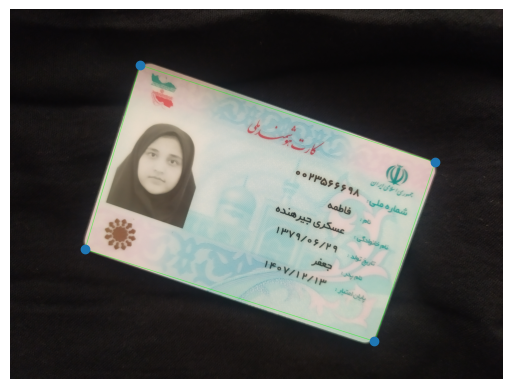

[[1054.  453.]
 [3448. 1242.]
 [2958. 2694.]
 [ 608. 1948.]]
70 70
National card


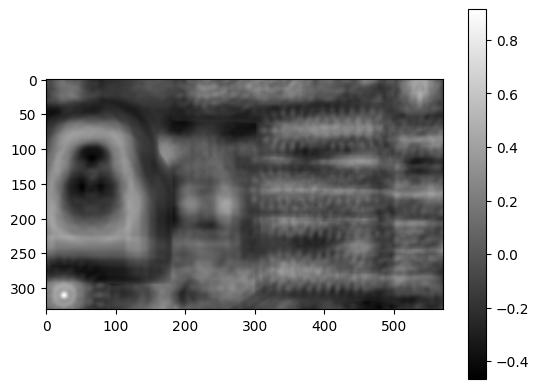

657


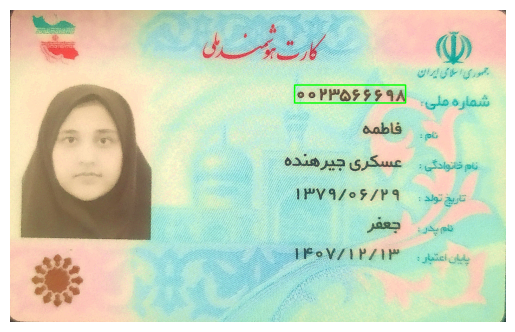

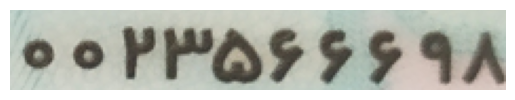

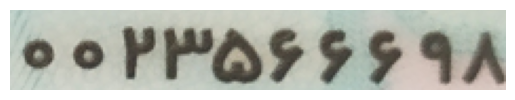

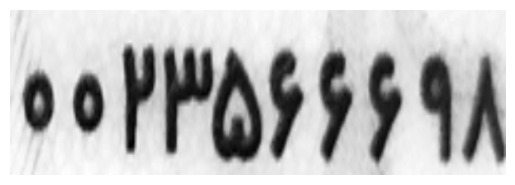

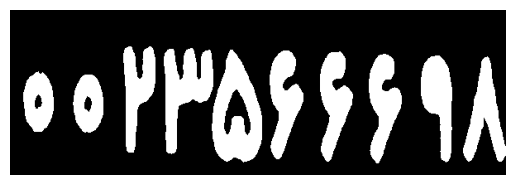

1/1 [==============================] - 0s 56ms/step
0023500068


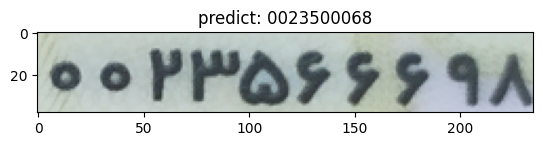

In [ ]:
import os
def predict():
  id_template=cv2.imread('/content/mypic/template.jpg')

  id_templategray=cv2.cvtColor(id_template , cv2.COLOR_BGR2GRAY)
  id_templategray = cv2.resize(id_templategray, (60, 60))
  folder_path = "/content/mypic"
  image_list = []

  for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") and filename != "template.jpg":
        image_list.append(os.path.join(folder_path, filename))
  for img_path in image_list:
    img=cv2.imread(img_path)
    print(img_path)
    finalimg=project(img)
    finalgray=cv2.cvtColor(finalimg,cv2.COLOR_BGR2GRAY)
    finalgrayresize=cv2.resize(finalgray, (640,400))
    # _, finalgrayresize = cv2.threshold(finalgray, 0, 255, cv2.THRESH_OTSU, cv2.THRESH_BINARY)
    # your code here #
    typecard=Cardrecognition(finalgrayresize,id_templategray)
    boxnum=detectboxnumbers(typecard,finalimg)
    imshow(boxnum)
    if typecard=='National card':
      digitn=splitdigitnational(boxnum)
      num=''
      for d in digitn:
        # print(str(predictnumbank(d)))
        num+=str(predictnumnational(d))
        # imshow(d)
      print(num)
      plt.imshow(boxnum)
      plt.title('predict: {}'.format(num))
      plt.show()

    else:
      digites=splitdigit(boxnum)
      num=''
      for d in digites:
        # print(str(predictnumbank(d)))
        num+=str(predictnumbank(d))
        # imshow(d)
      print(num)

      plt.imshow(boxnum)
      plt.title('predict: {}'.format(num))
      plt.show()


predict()

## part c - optional

In [ ]:
# your code here #

1/1 [==============================] - 1s 740ms/step


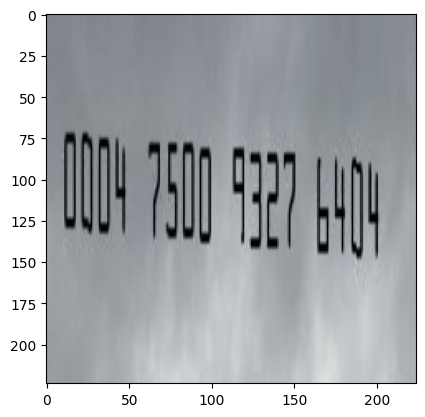

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

# Define a function to extract features from an image
def extract_features(image):
    # Load the VGG16 model
    model = VGG16()

    # Preprocess the image
    image = preprocess_input(image)

    # Extract features from the image
    features = model.predict(image.reshape(1, *image.shape))

    # Flatten the features
    features = features.flatten()

    return features

# Load bank card number image
card_number = cv2.imread("145.PNG")

# Resize card number image to the expected input size of VGG16
input_shape = (224, 224)
card_number = cv2.resize(card_number, input_shape)

# Extract features from card number image
card_number_features = extract_features(card_number)

# Create a list of areas
areas = [cv2.imread("36.jpg"), cv2.imread("00.PNG"), cv2.imread("98.PNG")]

# Iterate over areas and extract features for each area
best_similarity = -1
best_area = None
for area in areas:
    # Resize area to the expected input size of VGG16
    area = cv2.resize(area, input_shape)

    # Extract features from area
    area_features = extract_features(area)

    # Compute cosine similarity between area features and card number features
    similarity = np.dot(area_features, card_number_features.T) / (np.linalg.norm(area_features) * np.linalg.norm(card_number_features))

    # Update best similarity and best area if necessary
    if similarity > best_similarity:
        best_similarity = similarity
        best_area = area

# Display the best area using pyplot
plt.imshow(best_area[:,:,::-1])
plt.show()